### Import libraries

In [1]:
from PIL import Image
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import random


### Add some black lines to fit image in a squared matrix

In [2]:
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result


### Open image, resize it, and transform it to a matrix and find the right label

In [3]:
def image_to_matrix(path, size):
    image = Image.open(path)
    image = image.convert('L')
    image = expand2square(image, 0)
    image = image.resize((size, size))
    array = np.asarray(image) / 255
    array = np.reshape(array, (size, size, 1))

    # Use path to find the type
    type = [0]
    if 'bacteria' in path:
        type = [1]
    elif 'virus' in path:
        type = [2]
    return type, array

### Loading functions testing

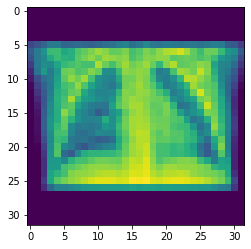

In [5]:
type, image_loaded = image_to_matrix("../chest_Xray/train/NORMAL/IM-0127-0001.jpeg", 32)

plt.imshow(image_loaded)

### Function to load all images in a directory, that produces a tuple with 3 lists

In [6]:
def load_dir(path, size):
    images = []
    labels = []
    for file in os.listdir(path):
        if '.jpeg' not in path + file:
            continue
        type, matrix = image_to_matrix(path + file, size)
        labels.append(type)
        images.append(matrix)
    return labels, images

### Final loading, produces a dataset with the training, test data. There are "shape" data who contains the image size

In [7]:
def load_with_shuffle(paths, size):
    images = []
    labels = []
    for path in paths:
        ret_labels, ret_images = load_dir(path, size)
        labels += ret_labels
        images += ret_images

    merged = list(zip(labels, images))
    random.shuffle(merged)
    return zip(*merged)

In [8]:
image_size = 32

path = "../dataset.hdf5"
if os.path.exists(path):
    os.unlink(path)

f = h5py.File(path, "w")

labels, images = load_with_shuffle(["../chest_Xray/train/NORMAL/", "../chest_Xray/train/PNEUMONIA/"], image_size)
grp = f.create_group('train')
grp.create_dataset('images', data=images)
grp.create_dataset('labels', data=labels)

labels, images = load_with_shuffle(["../chest_Xray/test/NORMAL/", "../chest_Xray/test/PNEUMONIA/"], image_size)
grp = f.create_group('test')
grp.create_dataset('images', data=images)
grp.create_dataset('labels', data=labels)

labels, images = load_with_shuffle(["../chest_Xray/val/NORMAL/", "../chest_Xray/val/PNEUMONIA/"], image_size)
grp = f.create_group('val')
grp.create_dataset('images', data=images)
grp.create_dataset('labels', data=labels)

shape_dts = f.create_dataset('shape', data=[image_size, image_size])

f.close()